<a href="https://colab.research.google.com/github/kty0307/Blog/blob/main/Text%20to%20SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 빅쿼리 연결

클라우드 빅쿼리에 project_id = 'river-nectar-469806-u4' dataset_id = 'loan' table_id => 'tb_a', 'tb_b', 'tb_c', 'tb_d' 이 정보를 바탕으로 쿼리 생성할 준비 마쳐주세요. 계정연결이 필요한 경우 진행해주세요.

# 2. 테이블 컬럼 명세

## 2.1. tb_a— 신청 마스터 (Application Master)

| 컬럼명 | 한글명 | 타입 (BigQuery) | 값/도메인 | 비고 |
|---|---|---|---|---|
| `loan_req_id` | 신청번호 | STRING | `R000001` ~ `R300000` | **PK** |
| `customer_id` | 고객번호 | STRING | `C000001` ~ `C300000` |  |
| `gender` | 성별 | STRING | `남`, `여` |  |
| `age` | 나이 | INT64 | 20 ~ 65 | 정수 |
| `income` | 소득 | INT64 | 0 ~ 999,999,999 | 원 단위 정수 |
| `realestate` | 거주형태 | STRING | `월세`, `전세`, `자가`, `가족과거주` |  |
| `occupation_cd` | 직업구분 | STRING | `자영업자`, `급여소득자`, `주부` |  |
| `application_date` | 신청일자 | DATE | 2025-04-01 ~ 2025-06-30 |  |
| `process_date` | 처리일자 | DATE | 2025-04-01 ~ 2025-06-30 |  |
| `inquiry_id` | 선택조회ID | STRING | `B000001`… 또는 NULL | tb_b 참조 |
| `final_loan_amount` | 최종대출금액 | FLOAT64 | NULL 또는 ≥ 0 | 실행 시 채움 |
| `final_rate` | 최종금리 | FLOAT64 | NULL 또는 > 0 | 실행 시 채움 |
| `execution_date` | 대출실행일자 | DATE | 2025-04-01 ~ 2025-06-30 |  |

## 2.2. tb_c— 한도/금리 조회 이력 (Limit Inquiry & Offer)

| 컬럼명 | 한글명 | 타입 (BigQuery) | 값/도메인 | 비고 |
|---|---|---|---|---|
| `loan_req_id` | 신청번호 | STRING | `R000001`… | tb_a 참조 |
| `inquiry_id` | 한도조회ID | STRING | `B000001`… | 재조회로 다건 가능 |
| `table_reg_no` | 등록순번 | INT64 | 1…(증가) | **유일키** |
| `product_id` | 상품구분 | STRING | `신용`, `오토` |  |
| `cb_score` | CB점수 | INT64 | 0 ~ 999 |  |
| `as_grade` | AS등급 | INT64 | 1 ~ 10 |  |
| `int_grade` | 금리등급 | INT64 | 1 ~ 6 |  |
| `limit_grade` | 한도등급 | INT64 | 1 ~ 6 |  |
| `inquiry_date` | 조회일자 | DATE | 2025-04-01 ~ 2025-06-30 |  |
| `offer_limit` | 제안한도 | INT64 | 0 또는 양의 정수 | 0 = 부여 없음 |
| `offer_rate` | 제안금리 | FLOAT64 | 0 또는 양의 실수 | 0 = 부여 없음 |
| `channel` | 채널 | STRING | `Toss`, `Kakao`, `Naver Pay`, `Direct`, `In-Direct` |  |
| `seg` | 세그먼트 | STRING | `SEG1`, `SEG2`, `SEG3`, `SEG4`, `SEG5` |  |

## 2.3.tb_c — 접수 상세 (Reception Detail)

| 컬럼명 | 한글명 | 타입 (BigQuery) | 값/도메인 | 비고 |
|---|---|---|---|---|
| `loan_req_id` | 신청번호 | STRING | `R000001`… | **PK**, tb_a 참조 |
| `reception_yn` | 접수여부 | BOOLEAN | true, false, NULL |  |
| `reception_product_id` | 접수상품 | STRING | `신용`, `오토` | tb_b의 `product_id`와 연계 |
| `reception_channel` | 접수채널 | STRING | `Toss`, `Kakao`, `Naver Pay`, `Direct`, `In-Direct` |  |

​

# 3. 테이블 로직 명세
테이블 로직 명세 (신청→조회→접수→실행)

​

본 데이터는 단순 관계가 아니라 실제 업무 흐름을 반영한다. 쿼리/집계는 반드시 이 순서를 전제.

​

테이블/관계

* tb_a(신청): PK=loan_req_id. 주요: application_date, process_date, inquiry_id, final_loan_amount, final_rate, execution_date.

* tb_b(한도조회): 유일키=table_reg_no. 동일 inquiry_id 재조회 다수. 주요: loan_req_id, inquiry_id, product_id, channel, inquiry_date, offer_limit, offer_rate.

* tb_c(접수): PK=loan_req_id. 주요: reception_yn('Y'/'N'/NULL), reception_product_id, reception_channel.

* 관계: A:B=1:N(loan_req_id), A:C=1:1. 최종 선택은 A.inquiry_id = B.inquiry_id. C↔B 연결은 C.loan_req_id=B.loan_req_id AND C.reception_product_id=B.product_id.

단계 요약

1. 신청: A에 1건 생성(상품/한도 미확정).

2. 한도조회: 상품별 제안 다수. B_latest(inquiry_id별 최신 1행) 생성: 정렬 table_reg_no DESC(BQ: ROW_NUMBER… QUALIFY rn=1).

3. 접수: 선택 시 C 기록, 미접수도 C에 기록(reception_yn='N').

* 집계 축 권장: kpi_channel = COALESCE(C.reception_channel, B_latest.channel), kpi_product = B_latest.product_id.

4. 실행: 접수된 건만 실행 기록(final_loan_amount, execution_date). 실행금액 ≤ 선택 제안 offer_limit. 미접수는 실행 NULL.

권장 조인

* A↔B: A.loan_req_id=B.loan_req_id(1:N), 선택상품은 A.inquiry_id=B.inquiry_id

* A↔C: A.loan_req_id=C.loan_req_id(1:1)

* C↔B: C.loan_req_id=B.loan_req_id AND C.reception_product_id=B.product_id

퍼널/지표 정의

* applications = COUNT(A)

* with_limit = (B_latest.offer_limit > 0)

* receptions = (C.reception_yn='Y')

* executions = (A.final_loan_amount IS NOT NULL)

무결성/검증

* C.reception_yn<>'Y' OR B_latest.offer_limit=0 인데 실행 존재 ⇒ 비정상(0건이어야 함)

* final_loan_amount ≤ B_latest.offer_limit

* execution_date ≥ process_date

날짜/BQ 팁

* YYYY-mm-DD Date형

* 기준일: 신청=A.application_date, 조회=B_latest.inquiry_date, 접수=A.process_date, 실행=A.execution_date

* 기간 필터는 DATE 컬럼에 적용. 대용량은 DATE 파티션(예: application_date, inquiry_date) + CLUSTER BY(inquiry_id, loan_req_id) 권장.

예외/보정

* A.inquiry_id가 NULL/무효면, 동일 loan_req_id의 (offer_limit>0) 중 최저 금리 inquiry_id로 대체 허용.

* 재조회 다수일 때는 항상 B_latest 값만 사용.

# 4. 분석

In [1]:
from google.colab import auth
from google.cloud import bigquery

# Authenticate to Google Cloud
auth.authenticate_user()

# Set the project ID
project_id = 'river-nectar-469806-u4'
client = bigquery.Client(project=project_id)

print(f"Connected to BigQuery project: {project_id}")

Connected to BigQuery project: river-nectar-469806-u4


In [2]:
query = """
SELECT
    SUM(a.final_loan_amount) AS total_loan_amount,
    AVG(a.final_rate) AS average_loan_rate
FROM
    `river-nectar-469806-u4.loan.tb_a` AS a
JOIN
    `river-nectar-469806-u4.loan.tb_c` AS c
ON
    a.loan_req_id = c.loan_req_id
WHERE
    c.reception_channel = 'Toss'
    AND a.execution_date BETWEEN '2025-04-01' AND '2025-04-30'
    AND a.final_loan_amount IS NOT NULL
"""

query_job = client.query(query)
results = query_job.result()

for row in results:
    print(f"Total Loan Amount (Toss, April): {row.total_loan_amount}")
    print(f"Average Loan Rate (Toss, April): {row.average_loan_rate}")

Total Loan Amount (Toss, April): 11355547088.0
Average Loan Rate (Toss, April): 14.330540777887204


In [12]:
# Query to perform funnel analysis by month and channel, assuming c.reception_yn is BOOLEAN
funnel_query_monthly_channel = """
WITH
  B_ranked AS (
    SELECT
      loan_req_id,
      inquiry_id,
      product_id,
      channel,
      inquiry_date,
      offer_limit,
      offer_rate,
      ROW_NUMBER() OVER(PARTITION BY inquiry_id ORDER BY table_reg_no DESC) as rn
    FROM
      `river-nectar-469806-u4.loan.tb_b`
  ),
  B_latest AS (
    SELECT
      loan_req_id,
      inquiry_id,
      product_id,
      channel,
      inquiry_date,
      offer_limit,
      offer_rate
    FROM
      B_ranked
    WHERE
      rn = 1
  )
SELECT
    FORMAT_DATE('%Y-%m', a.application_date) AS application_month,
    COALESCE(c.reception_channel, b.channel) AS kpi_channel, -- Recommended KPI channel
    COUNT(DISTINCT a.loan_req_id) AS applications, -- 신청 (tb_a)
    COUNT(DISTINCT CASE WHEN b.offer_limit > 0 THEN a.loan_req_id END) AS model_approvals, -- 모형승인 (B_latest where offer_limit > 0)
    COUNT(DISTINCT CASE WHEN c.reception_yn = TRUE THEN a.loan_req_id END) AS receptions, -- 접수 (tb_c where reception_yn = TRUE)
    COUNT(DISTINCT CASE WHEN a.final_loan_amount IS NOT NULL THEN a.loan_req_id END) AS executions -- 실행 (tb_a where final_loan_amount IS NOT NULL)
FROM
    `river-nectar-469806-u4.loan.tb_a` AS a
LEFT JOIN
    B_latest AS b ON a.inquiry_id = b.inquiry_id -- Join with the latest inquiry based on selected inquiry_id
LEFT JOIN
    `river-nectar-469806-u4.loan.tb_c` AS c ON a.loan_req_id = c.loan_req_id -- Join with reception table
GROUP BY
    application_month,
    kpi_channel
ORDER BY
    application_month,
    kpi_channel
"""

query_job = client.query(funnel_query_monthly_channel)
results_df = query_job.to_dataframe() # Load results into a pandas DataFrame

print("Monthly and Channel Funnel Analysis Results:")
display(results_df) # Display the DataFrame as a table

Monthly and Channel Funnel Analysis Results:


,application_month,kpi_channel,applications,model_approvals,receptions,executions
0,2025-04,Direct,9907,2204,1178,299
1,2025-04,In-Direct,9903,2251,1114,264
2,2025-04,Kakao,44724,10139,5369,1389
3,2025-04,Naver Pay,4992,1165,603,166
4,2025-04,Toss,29452,6737,3401,859
5,2025-05,Direct,10316,2333,1231,320
6,2025-05,In-Direct,10194,2335,1188,275
7,2025-05,Kakao,45944,10347,5449,1393
8,2025-05,Naver Pay,5037,1149,564,134
9,2025-05,Toss,30870,7057,3644,910


In [13]:
# Install necessary libraries
%pip install matplotlib seaborn

/tmp/ipython-input-939363624.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




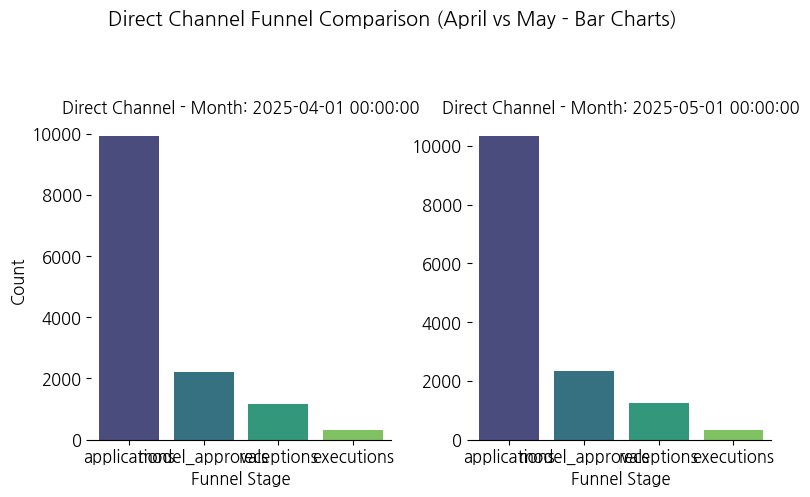

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the 'application_month' column is treated as a datetime object for proper sorting
results_df['application_month'] = pd.to_datetime(results_df['application_month'])

# Melt the DataFrame to long format for easier plotting
melted_df = results_df.melt(
    id_vars=['application_month', 'kpi_channel'],
    value_vars=['applications', 'model_approvals', 'receptions', 'executions'],
    var_name='funnel_stage',
    value_name='count'
)

# Define the order of funnel stages for consistent plotting
stage_order = ['applications', 'model_approvals', 'receptions', 'executions']
melted_df['funnel_stage'] = pd.Categorical(melted_df['funnel_stage'], categories=stage_order, ordered=True)

# Filter for 'Direct' channel in April and May data for bar plots
# Reuse the filtered data from the Plotly attempt if available, or re-filter
if 'direct_april_may_df' in locals():
    # Use the already filtered DataFrame
    direct_april_may_melted_df = direct_april_may_df.melt(
        id_vars=['application_month', 'kpi_channel'],
        value_vars=['applications', 'model_approvals', 'receptions', 'executions'],
        var_name='funnel_stage',
        value_name='count'
    )
    direct_april_may_melted_df['funnel_stage'] = pd.Categorical(direct_april_may_melted_df['funnel_stage'], categories=stage_order, ordered=True)
    data_to_plot = direct_april_may_melted_df
else:
    # If direct_april_may_df is not available, filter from melted_df
    data_to_plot = melted_df[
        (melted_df['kpi_channel'] == 'Direct') &
        (melted_df['application_month'].dt.strftime('%Y-%m').isin(['2025-04', '2025-05']))
    ]


# Create separate bar plots for each month for the 'Direct' channel
g = sns.catplot(
    data=data_to_plot, # Use the filtered DataFrame
    x='funnel_stage',
    y='count',
    # hue='kpi_channel', # Remove hue as we only have one channel
    col='application_month', # Create separate plots for each month
    kind='bar',
    height=5,
    aspect=.8,
    palette='viridis', # Palette might not be needed without hue, but keep for consistency if desired
    sharey=False # Allow y-axes to vary per month for better detail
)

# Improve plot readability
g.set_axis_labels("Funnel Stage", "Count")
g.set_titles("Direct Channel - Month: {col_name}")
g.despine(left=True)
g.fig.suptitle('Direct Channel Funnel Comparison (April vs May - Bar Charts)', y=1.02) # Add a title to the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap

# Display the plots
plt.show()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


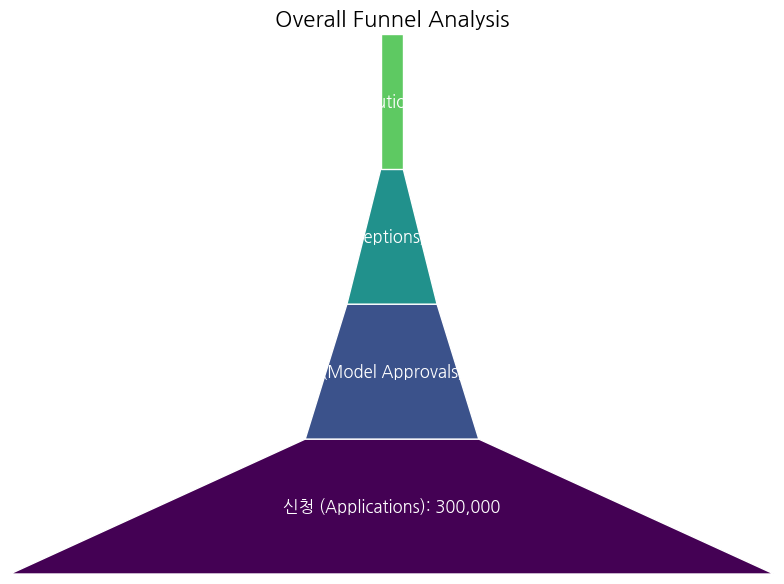

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.font_manager as fm

# Install a Korean font
!apt-get update -qq
!apt-get install fonts-nanum -qq > /dev/null

# Configure matplotlib to use the Korean font
fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # Change to the font file installed
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.family': 'NanumGothic', 'font.size': 12}) # Set font and size
plt.rcParams['axes.unicode_minus'] = False # Correctly display minus signs

# Aggregate the data to get total counts for each funnel stage across all months and channels
total_funnel_counts = results_df[['applications', 'model_approvals', 'receptions', 'executions']].sum().reset_index()
total_funnel_counts.columns = ['funnel_stage', 'count']

# Define the order of funnel stages
stage_order = ['applications', 'model_approvals', 'receptions', 'executions']
total_funnel_counts['funnel_stage'] = pd.Categorical(total_funnel_counts['funnel_stage'], categories=stage_order, ordered=True)
total_funnel_counts = total_funnel_counts.sort_values('funnel_stage')

# --- Create the Funnel Chart ---

# Define plot parameters
stage_labels = ['신청 (Applications)', '모형승인 (Model Approvals)', '접수 (Receptions)', '실행 (Executions)']
counts = total_funnel_counts['count'].tolist()
max_count = max(counts)
# Use counts as widths, normalize by max_count
widths = counts

# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate vertical positions for each segment
y_positions = np.arange(len(stage_labels) + 1) * 1.0 # Vertical spacing

# Draw funnel segments (trapezoids or rectangles)
# Start with the widest segment at the bottom (applications) and go up
for i in range(len(stage_labels)):
    # Calculate the width at the top and bottom of the current segment
    bottom_width = widths[i]
    top_width = widths[i] if i == len(stage_labels) -1 else widths[i+1] # Top width is the count of the next stage, except for the last stage

    # Calculate the x-coordinates for the corners of the trapezoid
    # Center the trapezoid: (max_count - width) / 2 to (max_count + width) / 2
    bottom_left = (max_count - bottom_width) / 2
    bottom_right = (max_count + bottom_width) / 2
    top_left = (max_count - top_width) / 2
    top_right = (max_count + top_width) / 2

    # Define the vertices of the trapezoid [bottom-left, bottom-right, top-right, top-left]
    verts = [
        (bottom_left, y_positions[i]),
        (bottom_right, y_positions[i]),
        (top_right, y_positions[i+1]),
        (top_left, y_positions[i+1])
    ]

    # Create and add the polygon (trapezoid) to the plot
    poly = plt.Polygon(verts, facecolor=plt.cm.viridis(i/len(stage_labels)), edgecolor='white')
    ax.add_patch(poly)

    # Add labels and counts in the center of each segment
    center_x = max_count / 2
    center_y = (y_positions[i] + y_positions[i+1]) / 2
    ax.text(center_x, center_y, f'{stage_labels[i]}: {counts[i]:,}',
            ha='center', va='center', color='white', fontsize=12, fontweight='bold')


# --- Customize Plot Appearance ---
ax.set_ylim(0, y_positions[-1]) # Set y-limits
ax.set_xlim(0, max_count) # Set x-limits based on max count
ax.axis('off') # Hide axes

ax.set_title('Overall Funnel Analysis', fontsize=16)

plt.tight_layout()
plt.show()

In [20]:
# Install plotly
%pip install plotly

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Ensure the 'application_month' column is treated as a datetime object for proper sorting
results_df['application_month'] = pd.to_datetime(results_df['application_month'])

# Filter data for Direct channel in April and May
direct_april_may_df = results_df[
    (results_df['kpi_channel'] == 'Direct') &
    (results_df['application_month'].dt.strftime('%Y-%m').isin(['2025-04', '2025-05']))
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Define the order of funnel stages
stage_order = ['applications', 'model_approvals', 'receptions', 'executions']
stage_labels = ['신청 (Applications)', '모형승인 (Model Approvals)', '접수 (Receptions)', '실행 (Executions)']

# Prepare data for Plotly Funnel
april_data = direct_april_may_df[direct_april_may_df['application_month'].dt.strftime('%Y-%m') == '2025-04'].iloc[0]
may_data = direct_april_may_df[direct_april_may_df['application_month'].dt.strftime('%Y-%m') == '2025-05'].iloc[0]

april_counts = [april_data[stage] for stage in stage_order]
may_counts = [may_data[stage] for stage in stage_order]


# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Direct Channel - April 2025', 'Direct Channel - May 2025'))

# Add April Funnel trace
fig.add_trace(go.Funnel(
    name='April 2025',
    y=stage_labels,
    x=april_counts,
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"]},
    connector = {"line": {"color": "gray", "dash": "dot"}}
), 1, 1) # Add to row 1, column 1

# Add May Funnel trace
fig.add_trace(go.Funnel(
    name='May 2025',
    y=stage_labels,
    x=may_counts,
    textposition = "inside",
    textinfo = "value+percent initial",
    marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal"]},
    connector = {"line": {"color": "gray", "dash": "dot"}}
), 1, 2) # Add to row 1, column 2

# Update layout
fig.update_layout(
    title_text="Direct Channel Funnel Comparison (April vs May)",
    hovermode='closest'
)

# Show the plot
fig.show()